In [13]:
# Import libraries
import torch
import numpy as np
from IPython.display import Audio 
import librosa
import matplotlib.pyplot as plt
from models import SpectrogramGenerator
import json
import torch
from hifigan.__init__ import AttrDict
from hifigan.hifigan import Vocoder
from preprocess import preprocess_audio
import utils

# Define configure files and parameters
config_file = 'config.json'
with open(config_file, 'r') as file:
    config = json.load(file)
h = AttrDict(config)

n_fft=config['n_fft']
n_mels=config['num_mels']
samplerate=16000
hop_size=config['hop_size']
win_size=config['win_size']
fmin=config['fmin']
fmax=config['fmax']
signal_length = 64000
MAX_WAV_VALUE = config['MAX_WAV_VALUE']

audio_path = config['audio_dir']
n_classes = utils.get_n_classes(audio_path)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

#torch.manual_seed(h.seed)

Found 7 different classes in /home/rein/Downloads/development-dataset/
Using device: cuda:0


In [14]:
# Loudness extraction from a wave file
audio_file = '/home/rein/Downloads/development-dataset/Footstep/002.wav'
_, loudness, _, _ = preprocess_audio(audio_file, n_fft, n_mels, samplerate, hop_size, win_size, signal_length, device, oneshot=True)
loudness = torch.tensor(loudness,dtype=torch.float32).to(device)
#loudness = torch.cat((loudness[2], loudness[4]), dim=1)
loudness = loudness.view(1, loudness.size(0),1)
seq_len = loudness.size(1)

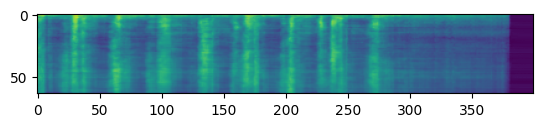

In [20]:
# Generator initialization
generator = SpectrogramGenerator(n_classes, seq_len)
generator.to(device)
generator.load_state_dict(torch.load('/home/rein/Documents/GAN-conv1d/saved_model/12-11-2023_23_RNN-GAN-all/generator_6000.pt'))
generator.eval()

# Latent vector definition 
z = torch.ones(1, 100).to(device)*3
# z1 = torch.ones(1, 50)*-3
# z2 = torch.ones(1, 50)*3
# z = torch.cat((z1, z2), dim=1)
label = torch.tensor([1]).to(device)

fake_imgs = generator(z, loudness, label)
melspec = fake_imgs.detach().cpu().numpy()

max_val = np.load('preprocessed/max_val.npy')
min_val = np.load('preprocessed/min_val.npy')

# Rescale spectrogram
melspec = utils.min_max_denormalize(melspec, min_val, max_val)
melspec = melspec[0,:,:,:]
melspec = np.transpose(melspec, (0, 2, 1))
plt.imshow(melspec.squeeze())

In [21]:
# Apply vocoder
waveform1 = utils.inference(melspec, MAX_WAV_VALUE, Vocoder, h, device)
Audio(waveform1, rate=samplerate)

In [7]:
waveform2 = utils.inference(melspec, MAX_WAV_VALUE, Vocoder, h, device)
print(np.mean(waveform1-waveform2))

0.0


In [ ]:
import torch.nn as nn
class SpectrogramGenerator(nn.Module):
    def __init__(self, latent_dim=100, loudness_dim=1, hidden_dim=512, n_layers=3):
        super(SpectrogramGenerator, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        # Embedding for labels
        self.label_embedding = nn.Sequential(
            nn.Embedding(.n_classes, args.n_classes*10),
            nn.Linear(args.n_classes*10, 400)
        )
        label_dim = 1
        # If using a single latent vector, expand it to match the sequence length
        self.fc_init = nn.Linear(latent_dim + loudness_dim + label_dim, hidden_dim)

        # Define the RNN layer(s)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, n_layers, batch_first=True)

        # Define the output layer
        self.fc_out = nn.Linear(hidden_dim, 64)

    def forward(self, z, loudness, labels):
        # Assuming z is a batch of latent vectors and loudness is a sequence of loudness features
        seq_len = loudness.size(1)  # This should be 400

        # Expand the latent space to match the sequence length and concatenate with loudness
        z_expanded = z.unsqueeze(1).repeat(1, seq_len, 1)
        label_emb = self.label_embedding(labels).view(loudness.size(0), seq_len, 1)
        print(label_emb.shape)
        rnn_input = torch.cat((z_expanded, loudness, label_emb), dim=2)
        print(z_expanded.shape, rnn_input.shape)

        # Process the initial input to match the RNN input features
        rnn_input = self.fc_init(rnn_input)

        # Get the RNN output for the whole sequence
        rnn_out, _ = self.rnn(rnn_input)

        # Process the RNN outputs to the final spectrogram shape
        output_seq = self.fc_out(rnn_out.contiguous().view(-1, self.hidden_dim))
        spectrogram = output_seq.view(-1, 1, seq_len, 64)

        return spectrogram

In [ ]:
specgen = SpectrogramGenerator()
loudness = np.load('preprocessed/loudness.npy')
loudness = torch.tensor(loudness,dtype=torch.float32)
loudness = loudness[5]
loudness = torch.unsqueeze(loudness, 2)

z = torch.randn(1, args.latent_dim, dtype=torch.float32).to(device)
label = torch.tensor([0]).to(device)
spec = specgen(z,loudness, label)

NameError: name 'args' is not defined